## Code from https://www.educative.io/answers/real-time-emotion-detection-in-deep-learning

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

num_features = 64
num_labels = len(emotions)
batch_size = 64
epochs = 100
width, height = 48, 48

def load_images_from_folder(folder_path):
    images = []
    labels = []
    for emotion_idx, emotion in enumerate(emotions):
        emotion_folder = os.path.join(folder_path, emotion)
        for filename in os.listdir(emotion_folder):
            img = cv2.imread(os.path.join(emotion_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (width, height))
                images.append(img)
                labels.append(emotion_idx)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images\train")
test_images, test_labels = load_images_from_folder(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images\validation")

train_images_fer, train_labels_fer = load_images_from_folder(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\Archive2\train")
test_images_fer, test_labels_fer = load_images_from_folder(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\Archive2\test")

combined_train_images = np.concatenate((train_images, train_images_fer), axis=0)
combined_train_labels = np.concatenate((train_labels, train_labels_fer), axis=0)
                                       
combined_test_images = np.concatenate((test_images, test_images_fer), axis=0)
combined_test_labels = np.concatenate((test_labels, test_labels_fer), axis=0)

combined_train_images = combined_train_images.reshape(combined_train_images.shape[0], width, height, 1).astype('float32')
combined_test_images = combined_test_images.reshape(combined_test_images.shape[0], width, height, 1).astype('float32')
combined_train_images /= 255.0
combined_test_images /= 255.0

combined_train_labels = to_categorical(combined_train_labels, num_classes=num_labels)
combined_test_labels = to_categorical(combined_test_labels, num_classes=num_labels)

In [3]:

# Sökvägar till träningsmapparna för båda datasets
train_dir_1 =r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images\train"
train_dir_2 = r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\Archive2\train"

class_counts = {}

# Funktion för att räkna antalet bilder i en mapp
def count_images_in_folder(folder_path, class_counts):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):  # Kontrollera att det är en mapp
            if class_name in class_counts:
                class_counts[class_name] += len(os.listdir(class_path))
            else:
                class_counts[class_name] = len(os.listdir(class_path))

# Räkna bilder i båda träningsmapparna
count_images_in_folder(train_dir_1, class_counts)
count_images_in_folder(train_dir_2, class_counts)

# Visa antalet bilder i varje klass
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


angry: 7837 images
disgust: 815 images
fear: 8008 images
happy: 14262 images
neutral: 9834 images
sad: 9661 images
surprise: 5852 images


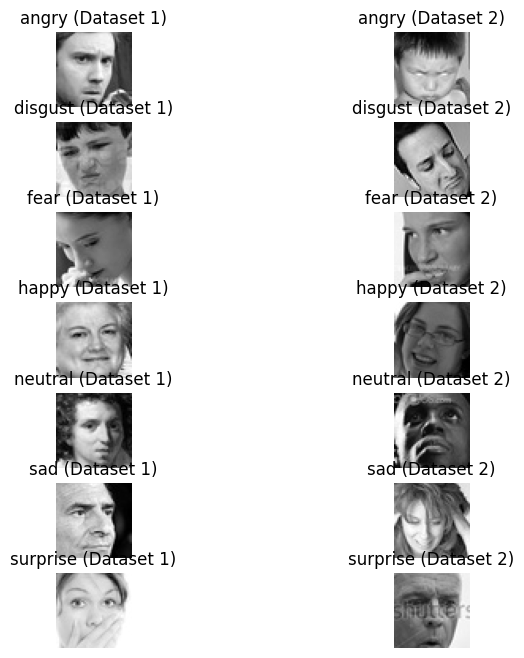

In [4]:

# Sökvägar till båda datasets
dataset1_base_dir = r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images\train"
dataset2_base_dir = r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\Archive2\train"

class_names = os.listdir(dataset1_base_dir)

plt.figure(figsize=(8, 8))

for i, class_name in enumerate(class_names):
    # Visa bild från första datasetet
    class_dir1 = os.path.join(dataset1_base_dir, class_name)
    img_name1 = os.listdir(class_dir1)[0]
    img_path1 = os.path.join(class_dir1, img_name1)
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)

    if img1 is not None:
        plt.subplot(len(class_names), 2, 2 * i + 1)
        plt.imshow(img1, cmap='gray')
        plt.title(f"{class_name} (Dataset 1)")
        plt.axis('off')
    else:
        print(f"Could not read image {img_path1} from Dataset 1")
    
    # Visa bild från andra datasetet
    class_dir2 = os.path.join(dataset2_base_dir, class_name)
    img_name2 = os.listdir(class_dir2)[0]
    img_path2 = os.path.join(class_dir2, img_name2)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)

    if img2 is not None:
        plt.subplot(len(class_names), 2, 2 * i + 2)
        plt.imshow(img2, cmap='gray')
        plt.title(f"{class_name} (Dataset 2)")
        plt.axis('off')
    else:
        print(f"Could not read image {img_path2} from Dataset 2")

plt.show()


In [5]:
print(os.listdir(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images\train"))
print(os.listdir(r"C:\Users\ASUS\OneDrive\Skrivbord\AI2\archive\images"))


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['images', 'train', 'validation']


In [14]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation='softmax'))

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
"""train_labels_class = np.argmax(combined_train_labels, axis=1)


class_weights_array = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_labels_class),
                                                  y=train_labels_class)

class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

In [15]:
 #Skapa en ImageDataGenerator med augmentation
datagen = ImageDataGenerator(
    rotation_range=10,     
    width_shift_range=0.1, 
    height_shift_range=0.1,
    zoom_range=0.1,       
    horizontal_flip=True    
)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

In [18]:


history = model.fit(datagen.flow(combined_train_images, combined_train_labels,
                    batch_size=batch_size),
                    epochs=epochs,
                    #verbose=1,
                    validation_data = (combined_test_images, combined_test_labels),
                    shuffle = True,
                    #class_weight=class_weights,
                    callbacks=early_stopping)


Epoch 1/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 275s 310ms/step - accuracy: 0.2409 - loss: 1.8411 - val_accuracy: 0.3180 - val_loss: 1.7390
Epoch 2/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 273s 310ms/step - accuracy: 0.2808 - loss: 1.7490 - val_accuracy: 0.3748 - val_loss: 1.6014
Epoch 3/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 275s 312ms/step - accuracy: 0.3373 - loss: 1.6673 - val_accuracy: 0.4276 - val_loss: 1.4763
Epoch 4/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 278s 316ms/step - accuracy: 0.3786 - loss: 1.5949 - val_accuracy: 0.4685 - val_loss: 1.3857
Epoch 5/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 266s 302ms/step - accuracy: 0.4127 - loss: 1.5119 - val_accuracy: 0.4954 - val_loss: 1.3225
Epoch 6/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 268s 304ms/step - accuracy: 0.4410 - loss: 1.4483 - val_accuracy: 0.5135 - val_loss: 1.2752
Epoch 7/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 260s 295ms/step - accuracy: 0.4574 - loss: 1.4088 - val_accuracy: 0.5366 - val_loss: 1.2288
Epoch 8/100
880/880 ━━━━━━━━━━━━━━━━━━━━ 255s 290ms/step - accuracy: 

In [19]:
model.save("model-2024-08-30.keras")
with open("model-2024-08-30.json", "w") as json_file:
    json_file.write(model.to_json())

In [21]:
loss, accuracy = model.evaluate(combined_test_images, combined_test_labels, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Loss: 0.8339
Test Accuracy: 69.40%


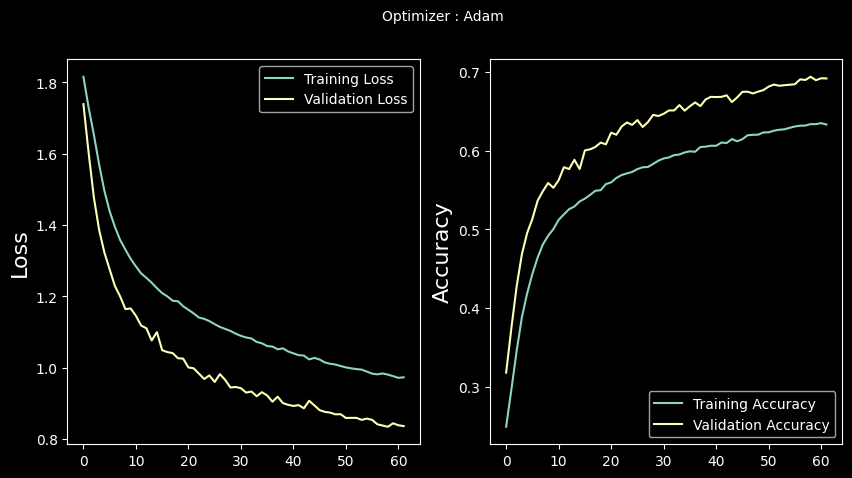

In [22]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [24]:


# Gör förutsägelser på testdatan
y_pred = model.predict(combined_test_images)
# Konvertera förutsägelserna från sannolikheter till klassetiketter
y_pred_classes = np.argmax(y_pred, axis=1)
# Konvertera de sanna etiketterna från one-hot till klassetiketter
y_true = np.argmax(combined_test_labels, axis=1)


446/446 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step


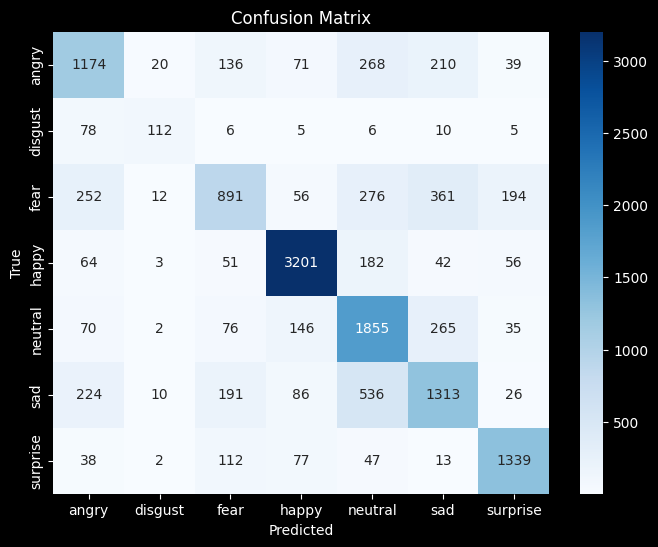

In [25]:


# Skapa confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisera confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
